In [1]:
# 导入包
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dense, Flatten

In [2]:
actions = np.array(['Afraid', 'Excited', 'Annoyed', 'Bored' , 'Angry' , 'Happy'])

In [3]:
indices_to_keep = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

In [4]:
label_map = {label:num for num, label in enumerate(actions)}

In [5]:
label_map

{'Afraid': 0, 'Excited': 1, 'Annoyed': 2, 'Bored': 3, 'Angry': 4, 'Happy': 5}

In [6]:
# 提取距离速度加速度方法
def calc_baseline(action_list):
    left_shoulder_right_shoulder_distance_list = []
    left_shoulder_left_elbow_distance_list = []
    left_elbow_left_wrist_distance_list = []
    left_hip_left_knee_distance_list = []
    std_list = []
    
    for i in range(len(action_list)):
        left_shoulder_right_shoulder_distance = math.hypot(action_list[i][11].x-action_list[i][12].x, action_list[i][11].y-action_list[i][12].y)
        left_shoulder_left_elbow_distance = math.hypot(action_list[i][11].x-action_list[i][13].x, action_list[i][11].y-action_list[i][13].y)
        left_elbow_left_wrist_distance = math.hypot(action_list[i][13].x-action_list[i][15].x, action_list[i][13].y-action_list[i][15].y)
        left_hip_left_knee_distance = math.hypot(action_list[i][23].x-action_list[i][25].x, action_list[i][23].y-action_list[i][25].y)
    
        left_shoulder_right_shoulder_distance_list.append(left_shoulder_right_shoulder_distance)
        left_shoulder_left_elbow_distance_list.append(left_shoulder_left_elbow_distance)
        left_elbow_left_wrist_distance_list.append(left_elbow_left_wrist_distance)
        left_hip_left_knee_distance_list.append(left_hip_left_knee_distance)
        
    std0 = np.array(left_shoulder_right_shoulder_distance_list).std() 
    std1 = np.array(left_shoulder_left_elbow_distance_list).std()
    std2 = np.array(left_elbow_left_wrist_distance_list).std()
    std3 = np.array(left_hip_left_knee_distance_list).std()
    std_list = [std0, std1, std2, std3]
    std_min = min(std_list)
    std_index = std_list.index(std_min)
    if std_index == 0:
        norm_list = left_shoulder_right_shoulder_distance_list
    elif std_index == 1:
        norm_list = left_shoulder_left_elbow_distance_list
    elif std_index == 2:
        norm_list = left_elbow_left_wrist_distance_list
    elif std_index == 3:
        norm_list = left_hip_left_knee_distance_list
    return norm_list, std_index


def calc_all(action_list):
    norm_list, std_num = calc_baseline(action_list)

    left_ankle_left_hip_distance_list = []
    right_ankle_right_hip_distance_list = []
    left_wrist_left_shoulder_distance_list = []
    right_wrist_right_shoulder_distance_list = []
    left_wrist_nose_distance_list = []
    right_wrist_nose_distance_list = []
    left_wrist_left_hip_distance_list = []
    right_wrist_right_hip_distance_list = []
    
    for i in range(len(action_list)):
        left_ankle_left_hip_distance        = math.hypot(action_list[i][27].x-action_list[i][23].x, action_list[i][27].y-action_list[i][23].y)
        right_ankle_right_hip_distance      = math.hypot(action_list[i][28].x-action_list[i][24].x, action_list[i][28].y-action_list[i][24].y)
        left_wrist_left_shoulder_distance   = math.hypot(action_list[i][15].x-action_list[i][11].x, action_list[i][15].y-action_list[i][11].y)
        right_wrist_right_shoulder_distance = math.hypot(action_list[i][16].x-action_list[i][12].x, action_list[i][16].y-action_list[i][12].y)
        left_wrist_nose_distance            = math.hypot(action_list[i][15].x-action_list[i][0].x, action_list[i][15].y-action_list[i][0].y)
        right_wrist_nose_distance           = math.hypot(action_list[i][16].x-action_list[i][0].x, action_list[i][16].y-action_list[i][0].y)
        left_wrist_left_hip_distance        = math.hypot(action_list[i][15].x-action_list[i][23].x, action_list[i][15].y-action_list[i][23].y)
        right_wrist_right_hip_distance      = math.hypot(action_list[i][16].x-action_list[i][24].x, action_list[i][16].y-action_list[i][24].y)

        left_ankle_left_hip_distance_list.append(left_ankle_left_hip_distance)
        right_ankle_right_hip_distance_list.append(right_ankle_right_hip_distance)
        left_wrist_left_shoulder_distance_list.append(left_wrist_left_shoulder_distance)
        right_wrist_right_shoulder_distance_list.append(right_wrist_right_shoulder_distance)
        left_wrist_nose_distance_list.append(left_wrist_nose_distance)
        right_wrist_nose_distance_list.append(right_wrist_nose_distance)
        left_wrist_left_hip_distance_list.append(left_wrist_left_hip_distance)
        right_wrist_right_hip_distance_list.append(right_wrist_right_hip_distance)
        
    # 计算速度
    left_ankle_velocity_list = []
    right_ankle_velocity_list = []
    left_hip_velocity_list = []
    right_hip_velocity_list = []
    left_wrist_velocity_list = []
    right_wrist_velocity_list = []

    for i in range(len(action_list)-1):
        left_ankle_velocity     = math.hypot(action_list[i+1][27].x-action_list[i][27].x, action_list[i+1][27].y-action_list[i][27].y)/cut_frame
        right_ankle_velocity    = math.hypot(action_list[i+1][28].x-action_list[i][28].x, action_list[i+1][28].y-action_list[i][28].y)/cut_frame
        left_hip_velocity       = math.hypot(action_list[i+1][23].x-action_list[i][23].x, action_list[i+1][23].y-action_list[i][23].y)/cut_frame
        right_hip_velocity      = math.hypot(action_list[i+1][24].x-action_list[i][24].x, action_list[i+1][24].y-action_list[i][24].y)/cut_frame
        left_wrist_velocity     = math.hypot(action_list[i+1][15].x-action_list[i][15].x, action_list[i+1][15].y-action_list[i][15].y)/cut_frame
        right_wrist_velocity    = math.hypot(action_list[i+1][16].x-action_list[i][16].x, action_list[i+1][16].y-action_list[i][16].y)/cut_frame

        left_ankle_velocity_list.append(left_ankle_velocity)
        right_ankle_velocity_list.append(right_ankle_velocity)
        left_hip_velocity_list.append(left_hip_velocity)
        right_hip_velocity_list.append(right_hip_velocity)
        left_wrist_velocity_list.append(left_wrist_velocity)
        right_wrist_velocity_list.append(right_wrist_velocity)
        
    # 计算加速度
    left_ankle_acceleration_list = []
    right_ankle_acceleration_list = []
    left_hip_acceleration_list = []
    right_hip_acceleration_list = []
    left_wrist_acceleration_list = []
    right_wrist_acceleration_list = []

    for i in range(len(action_list)-2):
        left_ankle_acceleration = (left_ankle_velocity_list[i+1]-left_ankle_velocity_list[i])/cut_frame
        right_ankle_acceleration= (right_ankle_velocity_list[i+1]-right_ankle_velocity_list[i])/cut_frame
        left_hip_acceleration   = (left_hip_velocity_list[i+1]-left_hip_velocity_list[i])/cut_frame 
        right_hip_acceleration  = (right_hip_velocity_list[i+1]-right_hip_velocity_list[i])/cut_frame 
        left_wrist_acceleration = (left_wrist_velocity_list[i+1]-left_wrist_velocity_list[i])/cut_frame  
        right_wrist_acceleration= (right_wrist_velocity_list[i+1]-right_wrist_velocity_list[i])/cut_frame

        left_ankle_acceleration_list.append(left_ankle_acceleration)
        right_ankle_acceleration_list.append(right_ankle_acceleration)
        left_hip_acceleration_list.append(left_hip_acceleration)
        right_hip_acceleration_list.append(right_hip_acceleration)
        left_wrist_acceleration_list.append(left_wrist_acceleration)
        right_wrist_acceleration_list.append(right_wrist_acceleration)
    
    # 计算DataFrame
    LMA_measurement = { 
        
                    'norm_d': pd.Series(data = norm_list),
    
                    #Body
                   'l_ankle_l_hip_d': pd.Series(data = left_ankle_left_hip_distance_list),
                   'r_ankle_r_hip_d': pd.Series(data = right_ankle_right_hip_distance_list),
                   'l_wrist_nose_d': pd.Series(data = left_wrist_nose_distance_list),
                   'r_wrist_nose_d': pd.Series(data = right_wrist_nose_distance_list),
                   'l_wrist_l_hip_d': pd.Series(data = left_wrist_left_hip_distance_list),
                   'r_wrist_r_hip_d': pd.Series(data = right_wrist_right_hip_distance_list),
                    #Effort velocity
                   'l_ankle_v': pd.Series(data = left_ankle_velocity_list),
                   'r_ankle_v': pd.Series(data = right_ankle_velocity_list),
                   'l_hip_v': pd.Series(data = left_hip_velocity_list),
                   'r_hip_v': pd.Series(data = right_hip_velocity_list),
                   'l_wrist_v': pd.Series(data = left_wrist_velocity_list),
                   'r_wrist_v': pd.Series(data = right_wrist_velocity_list),
                    #Effort acceleration
                   'l_ankle_a': pd.Series(data = left_ankle_acceleration_list),
                   'r_ankle_a': pd.Series(data = right_ankle_acceleration_list),
                   'l_hip_a': pd.Series(data = left_hip_acceleration_list),
                   'r_hip_a': pd.Series(data = right_hip_acceleration_list),
                   'l_wrist_a': pd.Series(data = left_wrist_acceleration_list),
                   'r_wrist_a': pd.Series(data = right_wrist_acceleration_list),   
                  }
    # 处理DataFrame
    LMA_measurement_df = pd.DataFrame(LMA_measurement)

    # 根据std位置不同，选择不同norm数据
    if std_num == 0:
        norm = LMA_measurement_df['norm_d']/40
    elif std_num == 1:
        norm = LMA_measurement_df['norm_d']/30
    elif std_num == 2:
        norm = LMA_measurement_df['norm_d']/25
    elif std_num == 3:
        norm = LMA_measurement_df['norm_d']/60
    Seven_LMA_measurement_norm_df = LMA_measurement_df.iloc[:, :7].div(norm, axis=0) 
    LMA_measurement_norm_df = pd.concat([Seven_LMA_measurement_norm_df, LMA_measurement_df.iloc[:, 7:]], axis=1)
    LMA_measurement_norm_df = LMA_measurement_norm_df.dropna()
    LMA_measurement_norm_df = LMA_measurement_norm_df.drop(columns = ['norm_d']) 
    return LMA_measurement_norm_df

# 归一化处理函数
def calc_norm(action_df):
    normalized = np.arctan(MinMaxScaler().fit_transform(action_df.T).T)
    norm_action_df = pd.DataFrame(normalized, columns=action_df.columns)
    return norm_action_df

In [7]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
label_list = []

train_path =  os.path.join(r"D:\anaconda\git\DANCE\BC_Dance_Clip_Change1\train")
for sub_folder in actions:
    print(sub_folder)
    for category_folder in os.listdir(train_path +'\\'+ sub_folder):
        print(category_folder)
        current_frame = 0
        for file in os.listdir(train_path + '\\'+ sub_folder + '\\' + category_folder):
            file_path = train_path + '\\'+ sub_folder + '\\' + category_folder + '\\' + file
#             print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            # 只提取精简之后关键点
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
merge_train = np.vstack(array_history) 

Afraid
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Excited
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Annoyed
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Bored
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Angry
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Happy
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8


In [8]:
merge_train.shape

(26553, 44)

In [9]:
len(label_list)

26553

In [10]:
counter = Counter(label_list)
Afraid_num =  counter[0]
Happy_num = counter[1]
Pleased_num = counter[2]
Bored_num = counter[3]
Relaxed_num = counter[4]
Annoyed_num = counter[5]
print(Afraid_num, Happy_num, Pleased_num, Bored_num, Relaxed_num, Annoyed_num)

4509 4509 4509 4509 4509 4008


In [11]:
# 整理训练集
X_train = merge_train
y_train = to_categorical(label_list).astype(int)

In [12]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
test_label_list = []

test_path =  os.path.join(r"D:\anaconda\git\DANCE\BC_Dance_Clip_Change1\test")
for sub_folder in actions:
    print(sub_folder)
    for category_folder in os.listdir(test_path +'\\'+ sub_folder):
        print(category_folder)
        current_frame = 0
        for file in os.listdir(test_path + '\\'+ sub_folder + '\\' + category_folder):
            file_path = test_path + '\\'+ sub_folder + '\\' + category_folder + '\\' + file
#             print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())

            # 标签分配
            for i in range(len(np_static_xy_list)):
                test_label_list.append(label_map[sub_folder])
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    test_label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
test_merge_train = np.vstack(array_history)   

Afraid
folder_9
Excited
folder_9
Annoyed
folder_9
Bored
folder_9
Angry
folder_9
Happy
folder_9


In [13]:
test_merge_train.shape

(3006, 44)

In [14]:
len(test_label_list)

91566

In [15]:
counter = Counter(test_label_list)
Afraid_num =  counter[0]
Happy_num = counter[1]
Pleased_num = counter[2]
Bored_num = counter[3]
Relaxed_num = counter[4]
Annoyed_num = counter[5]
print(Afraid_num, Happy_num, Pleased_num, Bored_num, Relaxed_num, Annoyed_num)

15261 15261 15261 15261 15261 15261


In [16]:
# 整理测试集
X_test = test_merge_train
y_test = to_categorical(test_label_list).astype(int)

In [17]:
train_indices = np.random.permutation(X_train.shape[0])
test_indices =  np.random.permutation(X_test.shape[0])

In [18]:
X_train = X_train[train_indices]
y_train = y_train[train_indices]

X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26553, 44), (26553, 6), (3006, 44), (3006, 6))

In [20]:
np.random.seed(0)
tf.random.set_seed(0)

Epoch 1/50


D:\anaconda\envs\SAM1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - categorical_accuracy: 0.2339 - loss: 1.7243 - val_categorical_accuracy: 0.1544 - val_loss: 1.8373
Epoch 2/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - categorical_accuracy: 0.4093 - loss: 1.4073 - val_categorical_accuracy: 0.1657 - val_loss: 1.9643
Epoch 3/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.4799 - loss: 1.2564 - val_categorical_accuracy: 0.1880 - val_loss: 2.0457
Epoch 4/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - categorical_accuracy: 0.5359 - loss: 1.1397 - val_categorical_accuracy: 0.2575 - val_loss: 2.0370
Epoch 5/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.5754 - loss: 1.0476 - val_categorical_accuracy: 0.2728 - val_loss: 2.0073
Epoch 6/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.6137 - loss: 0.9643 - val_categorical_accuracy: 0.2538 - val_loss: 2.3549
Epoch 7/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.6442 - loss: 0.8989 -

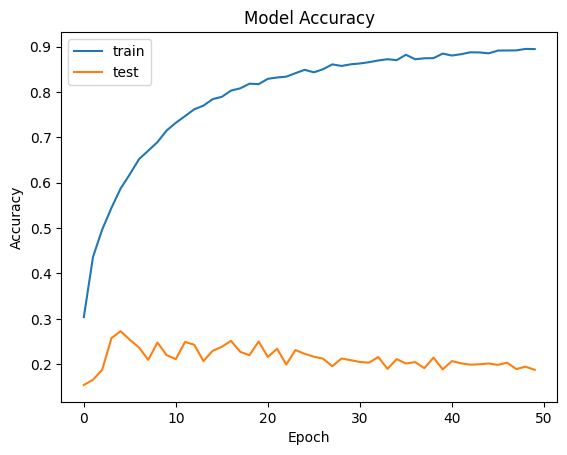

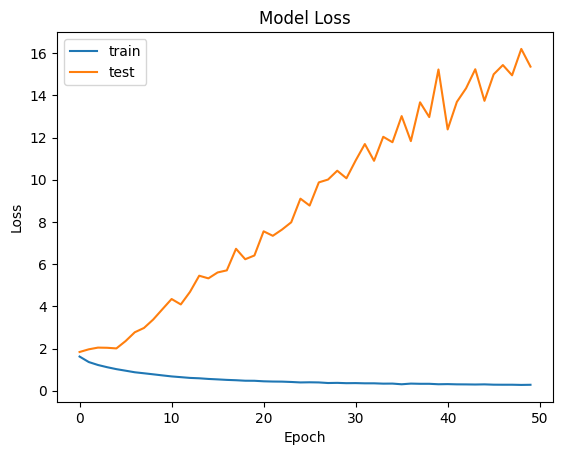

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 42, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 21, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 19, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,516 (1.02 MB)

 Trainable params: 88,838 (347.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 177,678 (694.06 KB)

In [21]:
# 数据预处理：对数据进行归一化
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为 CNN 需要的形状 (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 创建 CNN 模型
def create_cnn_model(input_shape):
    model = Sequential()

    # 第一层卷积层和池化层
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # 第二层卷积层和池化层
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # 展平数据以输入到全连接层
    model.add(Flatten())

    # 全连接层
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))  # 输出6个情感类别

    # 编译模型
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# 创建模型
cnn_model = create_cnn_model((44, 1))  # 输入形状为44维度特征，1个时间步

# 训练模型
history = cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 绘制训练过程中的准确率变化
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 绘制训练过程中的损失值变化
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 打印模型结构
cnn_model.summary()